[View in Colaboratory](https://colab.research.google.com/github/antoinemarchal/ROHSA/blob/master/ROHSApy.ipynb)

### About this notebook

This is a notebook to show you how to install and run ROHSA. It was built to run on [Google Colab](https://colab.research.google.com) but should work on many systems. This [link](https://colab.research.google.com/drive/1i5ehl1VVpe0JKxFEq0lscIo-ml5uWWtm) should find a version of this notebook launched on colab.

#### Notebook Authors:
Joshua Peek, Antoine Marchal

## Installing RHOSA
[ROHSA](https://github.com/antoinemarchal/ROHSA) is a code for decomposing PPV emission cubes into Gaussians. It is written in FORTRAN90 and thus needs to be installed via make. We clone the repository from github, change to the correct directory and make.

In [1]:
!git clone https://github.com/antoinemarchal/ROHSA.git ROHSA
import os
os.chdir('ROHSA/src')
!make
os.chdir('../../')

Cloning into 'ROHSA'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (355/355), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 1096 (delta 212), reused 188 (delta 64), pack-reused 741
Receiving objects: 100% (1096/1096), 4.96 MiB | 26.59 MiB/s, done.
Resolving deltas: 100% (719/719), done.
gfortran -O2 -Wall -Wno-uninitialized -ffixed-line-length-none -I/usr/local/include -c blas.f
gfortran -O2 -Wall -Wno-uninitialized -ffixed-line-length-none -I/usr/local/include -c lbfgsb.f
gfortran -O2 -Wall -Wno-uninitialized -ffixed-line-length-none -I/usr/local/include -c linpack.f
gfortran -O2 -Wall -Wno-uninitialized -ffixed-line-length-none -I/usr/local/include -c timer.f
gfortran -O2 -Wall -Wno-uninitialized -ffixed-line-length-none -I/usr/local/include -c mod_constants.f90
gfortran -O2 -Wall -Wno-uninitialized -ffixed-line-length-none -I/usr/local/include -c mod_convert.f90
gfortran -O2 -Wall -Wno-uninitialized -ffixed-line-length-none -I/usr

## Getting Data
Our example data comes from the GHIGLS Survey from Martin et al. 2015.  

In [2]:
!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_DFN_Tb.fits

--2018-10-20 10:45:00--  https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_DFN_Tb.fits
Resolving www.cita.utoronto.ca (www.cita.utoronto.ca)... 128.100.76.44
Connecting to www.cita.utoronto.ca (www.cita.utoronto.ca)|128.100.76.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2485440 (2.4M) [image/fits]
Saving to: ‘GHIGLS_DFN_Tb.fits’

GHIGLS_DFN_Tb.fits  100%[===================>]   2.37M  3.22MB/s    in 0.7s    

2018-10-20 10:45:02 (3.22 MB/s) - ‘GHIGLS_DFN_Tb.fits’ saved [2485440/2485440]



## Getting started with ROHSApy

### Installation

In [3]:
!pip install ROHSApy

    100% |████████████████████████████████| 6.0MB 4.7MB/s 


### Generate files for ROHSA with your data
Here we run cube2dat that converts the fits file to a dat file readable by FORTRAN and generate a parameters file to run the code.

In [4]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA

fitsname = "GHIGLS_DFN_Tb.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[0][150:350,:32,:32]

filename = "GHIGLS_DFN_Tb.dat" #@param
fileout = "GHIGLS_DFN_Tb_gauss_run_0.dat" #@param
filename_noise = ''
n_gauss = 2           #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100      #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                                     
lambda_mu = 100       #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                          
lambda_sig = 100      #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                                    
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 100. #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 400         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".false."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 

core = ROHSA(cube)            
core.cube2dat(filename=filename)
core.gen_parameters(filename=filename, 
                    fileout=fileout,  
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    save_grid=save_grid)

Generate GHIGLS_DFN_Tb.dat file
Generate parameters.dat file


### Running ROHSA
Here we run ROHSA on the data. This is invoking the parameter file parameters.txt. 
Note : If you want to use core.run() method, you have to add your executable in your own .bashrc - 
Here we use directly ROHSA from src

In [5]:
!./ROHSA/src/ROHSA parameters.txt

 
 opening file and reading data
 -------------------------------------------------------------------------
20 October 2018  10:45:21.820 AM
 
   ____     ___    _   _   ____       _    
  |  _ \   / _ \  | | | | / ___|     / \   
  | |_) | | | | | | |_| | \___ \    / _ \  
  |  _ <  | |_| | |  _  |  ___) |  / ___ \ 
  |_| \_\  \___/  |_| |_| |____/  /_/   \_\ 
 
  Version 1.2.1
  ROHSA is released as open source code
  Check out the documentation: https://antoinemarchal.github.io/ROHSA/
 
 run: ./ROHSA parameters.txt
 -------------------------------------------------------------------------
 fileout = 'GHIGLS_DFN_Tb_gauss_run_0.dat'

 ______Parameters_____

 n_gauss =            2
 n_gauss_add =            0
 lambda_amp =    100.00000000000000     
 lambda_mu =    100.00000000000000     
 lambda_sig =    100.00000000000000     
 lambda_var_amp =    0.0000000000000000     
 lambda_var_mu =    0.0000000000000000     
 lambda_var_sig =    100.00000000000000     
 amp_fact_init =   0.6600

### Reading the result of ROHSA
read_gaussian() method allows you to read the output file generated by ROHSA. The structure of the cube is the following : 

* dim 1 = Gaussian parameters / Ordering : amplitude - position - dispersion

* dim 2 and dim 3 = spatial axis

Note that position and dispersion are in pixel unit


In [6]:
Gaussian = core.read_gaussian("GHIGLS_DFN_Tb_gauss_run_0.dat")
print("dim cube = " + str(Gaussian.shape))

amplitude = Gaussian[0::3]
position = Gaussian[1::3]
dispersion = Gaussian[2::3]

Opening data file
dim cube = (6, 32, 32)


### Plot the first Gaussian component
Here we plot the amplitude, the position and the dispersion of the first Gaussian.

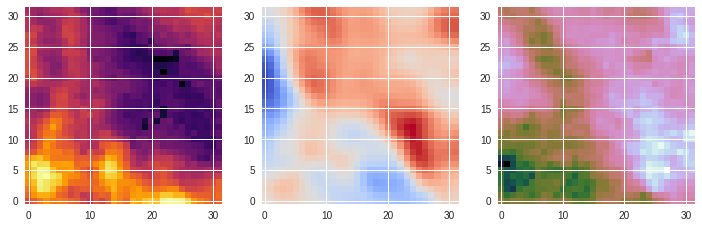

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(amplitude[0], origin="lower", cmap="inferno")
plt.subplot(1,3,2)
plt.imshow(position[0], origin="lower", cmap="coolwarm")
plt.subplot(1,3,3)
plt.imshow(dispersion[0], origin="lower", cmap="cubehelix")
